In [4]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
sns.set_theme(style="darkgrid")

In [5]:
data = load_iris()

In [6]:
data["data"].shape, data.keys(), data["feature_names"], data["target_names"], data["target"]


((150, 4),
 dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module']),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [7]:
X = data["data"]
Y = data["target"]

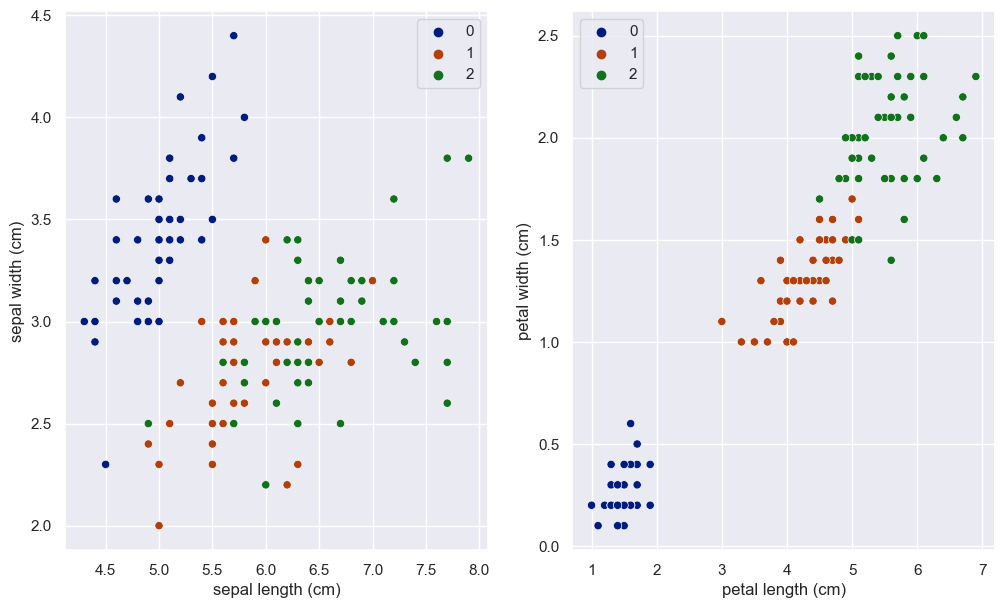

In [8]:
def plot_dataset():
    """
    Plots the dataset and returns axes ( which will be helpful in plotting decision boundary )
    """

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
    color_palette = "dark"
    axis_labels = data["feature_names"]

    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y,
                    ax=ax[0], palette=color_palette)
    ax[0].set_xlabel(axis_labels[0])
    ax[0].set_ylabel(axis_labels[1])

    sns.scatterplot(x=X[:, 2], y=X[:, 3], hue=Y,
                    ax=ax[1], palette=color_palette)
    ax[1].set_xlabel(axis_labels[2])
    ax[1].set_ylabel(axis_labels[3])
    return ax


ax = plot_dataset()

In [9]:
dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)

In [26]:
class Node:
    def __init__(self,
                 threshold: int = None,
                #  feature_name: int = None,
                 left: "Node" = None,
                 right: "Node" = None,
                 info_gain: int = None,
                 feature_index: int = None,
                 value: int = None,
                 ):

        # For Decision nodes
        self.threshold = threshold
        # self.feature_name = feature_name
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.feature_index = feature_index

        # For leaf nodes
        self.value = value


class DecisionTree:
    def __init__(self,
                 max_depth: int = 2,
                 min_samples: int = 2,):

        self.root = None
        self.max_depth = max_depth
        self.min_samples = min_samples


    # def print_tree(self, tree=None):
    #     print("hi")
    #     if tree is None:
    #         tree = self.root

    #     if tree.value is not None:
    #         print(f"value: {tree.value}")
    #     else:
    #         # print(f"{data['feature_names'][tree.feature_index]} ({tree.threshold})")
    #         print(tree.threshold)
    #         self.print_tree(tree=tree.left)
    #         self.print_tree(tree=tree.right)

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self,
            dataset):
        
        self.root = self.build_tree(dataset)

    def build_tree(self,
            dataset,
            current_depth=0):

        m = dataset.shape[0]
        if self.max_depth >= current_depth and self.min_samples <= m:
            best_split = self.get_best_split(dataset)

            if (best_split["info_gain"]) > 0:
                left_tree = self.build_tree(best_split["left_dataset"], current_depth+1)
                right_tree = self.build_tree(best_split["right_dataset"], current_depth+1)

                return Node(threshold=best_split["threshold"],
                            feature_index=best_split["choosen_feature_index"],
                            left=left_tree,
                            right=right_tree,
                            info_gain=best_split["info_gain"])
                
            
        return Node(value=self.get_value(dataset))
        # return self.root

    def get_value(self, 
                  dataset):

        labels, counts = np.unique(Y, return_counts=True)
        return labels[np.argmax(counts)]


    def get_best_split(self,
                       dataset):

        # return infogarin for this split and the left + right dataset
        stats = dict()
        stats["info_gain"] = -float("inf")
        stats["choosen_feature_index"] = -1
        stats["left_dataset"] = None
        stats["right_dataset"] = None
        stats["threshold"] = -1

        # excluding the class labels
        num_features = dataset.shape[1] - 1

        for feature_index in range((num_features)):

            # Get unique values for each features
            thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                info_gain_current, left_dataset, right_dataset = self.split(
                    dataset, feature_index, threshold)

                if len(left_dataset) > 0 and len(right_dataset) > 0:

                    if info_gain_current > stats["info_gain"]:

                        stats["info_gain"] = info_gain_current
                        stats["choosen_feature_index"] = feature_index
                        stats["left_dataset"] = left_dataset
                        stats["right_dataset"] = right_dataset
                        stats["threshold"] = threshold

        return stats

    def split(self,
              dataset,
              feature_index,
              threshold):

        left_dataset = dataset[dataset[:, feature_index] <= threshold]
        right_dataset = dataset[dataset[:, feature_index] > threshold]

        info_gain_current = self.information_gain(
            dataset, left_dataset, right_dataset)
        
        return (info_gain_current, left_dataset, right_dataset)

    def information_gain(self,
                         dataset,
                         left_dataset,
                         right_dataset):

        m = len(dataset)
        w_l = len(left_dataset) / m
        w_r = len(right_dataset) / m
        return self.entropy(dataset[:, -1]) - (w_l * self.entropy(left_dataset[:, -1]) + w_r * self.entropy(right_dataset[:, -1]))

    def entropy(self,
                Y):

        labels, counts = np.unique(Y, return_counts=True)
        probs = counts / len(Y)
        return -np.sum(probs * np.log2(probs))

In [27]:
tree = DecisionTree(max_depth=5)
tree.fit(dataset=dataset)

In [29]:
tree.print_tree()

X_2 <= 1.9 ? 0.9182958340544894
 left:0
 right:X_3 <= 1.7 ? 0.6901603707546748
  left:X_2 <= 4.9 ? 0.21317043093799645
    left:X_3 <= 1.6 ? 0.1460942501201363
        left:0
        right:0
    right:X_3 <= 1.5 ? 0.4591479170272448
        left:0
        right:X_0 <= 6.7 ? 0.9182958340544896
                left:0
                right:0
  right:X_2 <= 4.8 ? 0.09120811177442958
    left:X_0 <= 5.9 ? 0.9182958340544896
        left:0
        right:0
    right:0
